In [1]:
#!pip install catboost

In [2]:
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
print(f"catBoost version: {cb.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")

catBoost version: 1.2.2
numpy version: 1.26.0
pandas version: 2.1.1
seaborn version: 0.12.2


In [58]:
print('Loading Properties ...')
properties2016 = pd.read_csv('properties_2016.csv', low_memory = False)
properties2017 = pd.read_csv('properties_2017.csv', low_memory = False)

print('Loading Train ...')
train2016 = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)
train2017 = pd.read_csv('train_2017.csv', parse_dates=['transactiondate'], low_memory=False)

print('Loading Sample ...')
sample_submission = pd.read_csv('sample_submission.csv', low_memory = False)

print('Done ...')

Loading Properties ...
Loading Train ...
Loading Sample ...
Done ...


In [59]:
print(properties2016.shape)
print(properties2017.shape)
print(train2016.shape)
print(train2017.shape)
print(sample_submission.shape)

(2985217, 58)
(2985217, 58)
(90275, 3)
(77613, 3)
(2985217, 7)


## Exploring the csvs

In [60]:
train2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,1/1/2016
1,14366692,-0.1684,1/1/2016
2,12098116,-0.0040,1/1/2016
3,12643413,0.0218,2/1/2016
4,14432541,-0.0050,2/1/2016


In [61]:
train2017.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,1/1/2017
1,17052889,0.055619,1/1/2017
2,14186244,0.005383,1/1/2017
3,12177905,-0.103410,1/1/2017
4,10887214,0.006940,1/1/2017


In [62]:
properties2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [63]:
properties2017.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


In [64]:
sample_submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


## Observing sample submission parcelID order

In [65]:
sample_submission["ParcelId"].equals(properties2016["parcelid"])

True

In [66]:
sample_submission["ParcelId"].equals(properties2017["parcelid"])

False

The parcelid order in sample submission seems to follow that of 2016, thus we need to reorder 2017

### Reordering properties2017

In [67]:
properties2017 = pd.merge(sample_submission["ParcelId"], properties2017, how='left', left_on ='ParcelId',right_on='parcelid').drop("ParcelId", axis=1)
properties2017

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,110245.0,226900.0,2016.0,116655.0,3035.26,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,3.0,3.0,NaN,NaN,3.0,NaN,...,NaN,NaN,378466.0,762157.0,2016.0,383691.0,8653.10,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,...,NaN,NaN,201575.0,483188.0,2016.0,281613.0,5671.40,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,NaN,...,NaN,NaN,347863.0,578621.0,2016.0,230758.0,5894.36,NaN,NaN,NaN


In [68]:
sample_submission["ParcelId"].equals(properties2017["parcelid"])

True

## Splitting transaction dates into month, year (removing day)

In [69]:
def split_date(df):
    df["transactiondate"] = pd.to_datetime(df["transactiondate"], dayfirst=True)
    df["transaction_year"] = df["transactiondate"].dt.year
    
#     df["transaction_month"] = df["transactiondate"].dt.month

#     the code below is used if we want to let 2017 jan start as month 13 (might be useful when we combine both years to train a model)
    df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month

    
#     df["transaction_day"] = df["transactiondate"].dt.day
    
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

train2016 = split_date(train2016)
train2017 = split_date(train2017)

In [70]:
print(train2016.shape)
train2016.head()

(90275, 4)


,parcelid,logerror,transaction_year,transaction_month
0,11016594,0.0276,2016,1
1,14366692,-0.1684,2016,1
2,12098116,-0.0040,2016,1
3,12643413,0.0218,2016,1
4,14432541,-0.0050,2016,1


In [71]:
print(train2017.shape)
train2017.head()

(77613, 4)


,parcelid,logerror,transaction_year,transaction_month
0,14297519,0.025595,2017,13
1,17052889,0.055619,2017,13
2,14186244,0.005383,2017,13
3,12177905,-0.103410,2017,13
4,10887214,0.006940,2017,13


we can see that Jan 2017 starts as month 13

## Non-Null counts for the columns in properties.csv

In [72]:
properties2016.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   parcelid                      2985217 non-null  int64  
 1   airconditioningtypeid         811519 non-null   float64
 2   architecturalstyletypeid      6061 non-null     float64
 3   basementsqft                  1628 non-null     float64
 4   bathroomcnt                   2973755 non-null  float64
 5   bedroomcnt                    2973767 non-null  float64
 6   buildingclasstypeid           12629 non-null    float64
 7   buildingqualitytypeid         1938488 non-null  float64
 8   calculatedbathnbr             2856305 non-null  float64
 9   decktypeid                    17096 non-null    float64
 10  finishedfloor1squarefeet      202717 non-null   float64
 11  calculatedfinishedsquarefeet  2929652 non-null  float64
 12  finishedsquarefeet12        

## Labelling our original numerical & categorical columns

In [73]:
nominal_features = ["censustractandblock",
                    "airconditioningtypeid",
                    "architecturalstyletypeid",
                    "buildingclasstypeid",
                    "decktypeid",
                    "fips",
                    "heatingorsystemtypeid",
                    "propertycountylandusecode",
                    "propertylandusetypeid",
                    "regionidcounty",
                    "storytypeid",
                    "typeconstructiontypeid",
                    "rawcensustractandblock",
                    "regionidneighborhood",
                    "propertyzoningdesc",
                    "regionidcity",
                    "regionidzip",
                    "hashottuborspa",
                    "fireplaceflag",
                    "pooltypeid10",
                    "pooltypeid2",
                    "pooltypeid7",
                    "taxdelinquencyflag"                    
                   ]

ordinal_features = ["bathroomcnt",
                    "bedroomcnt",
                    "buildingqualitytypeid",
                    "calculatedbathnbr",
                    "threequarterbathnbr",
                    "fireplacecnt",
                    "fullbathcnt",
                    "garagecarcnt",
                    "numberofstories",
                    "poolcnt",
                    "roomcnt",
                    "unitcnt",
                    "taxdelinquencyyear",
                    "yearbuilt",
                    "assessmentyear"] 

categorical_features = nominal_features + ordinal_features

#we have to include the transaction date individual features that we created
categorical_features += ["transaction_year", "transaction_month"]

numeric_features = ["basementsqft",
                    "finishedfloor1squarefeet",
                    "calculatedfinishedsquarefeet",
                    "finishedsquarefeet6",
                    "finishedsquarefeet12",
                    "finishedsquarefeet13",
                    "finishedsquarefeet15",
                    "finishedsquarefeet50",
                    "garagetotalsqft",
                    "latitude",
                    "longitude",
                    "lotsizesquarefeet",
                    "poolsizesum",
                    "yardbuildingsqft17",
                    "yardbuildingsqft26",
                    "taxvaluedollarcnt",
                    "structuretaxvaluedollarcnt",
                    "landtaxvaluedollarcnt",
                    "taxamount"]

## Possible cleaning of dataframe  

 ### 1) remove the features with 1 unique value 

In [74]:
oneUniqueValueList2016 = []

for i in properties2016.columns:
    uniqueNum = properties2016[i].nunique()
    
    if uniqueNum == 1:
        oneUniqueValueList2016.append(i)
    
    
oneUniqueValueList2016

['decktypeid',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'fireplaceflag',
 'taxdelinquencyflag']

In [75]:
oneUniqueValueList2017 = []

for i in properties2017.columns:
    uniqueNum = properties2017[i].nunique()
    
    if uniqueNum == 1:
        oneUniqueValueList2017.append(i)
    
    
oneUniqueValueList2017

['decktypeid',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'fireplaceflag',
 'taxdelinquencyflag']

Both 2016 and 2017 have the same columns that only has 1 unique value, thus we will be removing them

### Removing above elements from our list

In [76]:
new_categorical_features = list(set(categorical_features) - set(oneUniqueValueList2017))
new_categorical_features

['typeconstructiontypeid',
 'bedroomcnt',
 'censustractandblock',
 'threequarterbathnbr',
 'fips',
 'assessmentyear',
 'regionidzip',
 'yearbuilt',
 'rawcensustractandblock',
 'regionidcounty',
 'bathroomcnt',
 'propertycountylandusecode',
 'regionidneighborhood',
 'taxdelinquencyyear',
 'transaction_year',
 'buildingclasstypeid',
 'transaction_month',
 'fullbathcnt',
 'propertylandusetypeid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'fireplacecnt',
 'roomcnt',
 'regionidcity',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'propertyzoningdesc',
 'garagecarcnt',
 'numberofstories',
 'heatingorsystemtypeid',
 'unitcnt']

### Removing above elements from our df

In [77]:
properties2016.drop(oneUniqueValueList2016, inplace = True, axis=1)
properties2017.drop(oneUniqueValueList2017, inplace = True, axis=1)

print(properties2016.shape)
print(properties2017.shape)

(2985217, 49)
(2985217, 49)


In [80]:
print(f"numeric features length: {len(numeric_features)}")
print(f"categorical features length: {len(new_categorical_features)}")

numeric features length: 19
categorical features length: 31


## Preparing our train and test data

- our first approach is to combine both 2016 and 2017 data and train a model that predicts both years together
- we have to merge train.csv with their respective properties.csv


In [81]:
# how = left is equivalent to a left join in SQL, thus we will only have a dataframe with houses that are sold
combined2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')  
combined2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')

print(combined2016.shape)
print(combined2017.shape)

(90275, 52)
(77613, 52)


In [82]:
#we can see the merging of both train and properties
combined2016.head()

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,6.037107e+13
1,14366692,-0.1684,2016,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN
2,12098116,-0.0040,2016,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,6.037464e+13
3,12643413,0.0218,2016,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,6.037296e+13
4,14432541,-0.0050,2016,1,NaN,NaN,NaN,2.5,4.0,NaN,...,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,6.059042e+13


In [83]:
# combining 2016 and 2017 for the final df
combined = pd.concat([combined2016, combined2017])
combined

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,2016,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,6.037107e+13
1,14366692,-0.168400,2016,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN
2,12098116,-0.004000,2016,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,6.037464e+13
3,12643413,0.021800,2016,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,6.037296e+13
4,14432541,-0.005000,2016,1,NaN,NaN,NaN,2.5,4.0,NaN,...,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,10833991,-0.002245,2017,21,1.0,NaN,NaN,3.0,3.0,NaN,...,NaN,1980.0,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,6.037132e+13
77609,11000655,0.020615,2017,21,NaN,NaN,NaN,2.0,2.0,NaN,...,NaN,1940.0,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,6.037101e+13
77610,17239384,0.013209,2017,21,NaN,NaN,NaN,2.0,4.0,NaN,...,NaN,1964.0,1.0,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,6.111008e+13
77611,12773139,0.037129,2017,21,1.0,NaN,NaN,1.0,3.0,NaN,...,NaN,1954.0,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,6.037434e+13


### Jinruis Preprocessing (Checking correlation of numerical cols)

<Axes: >

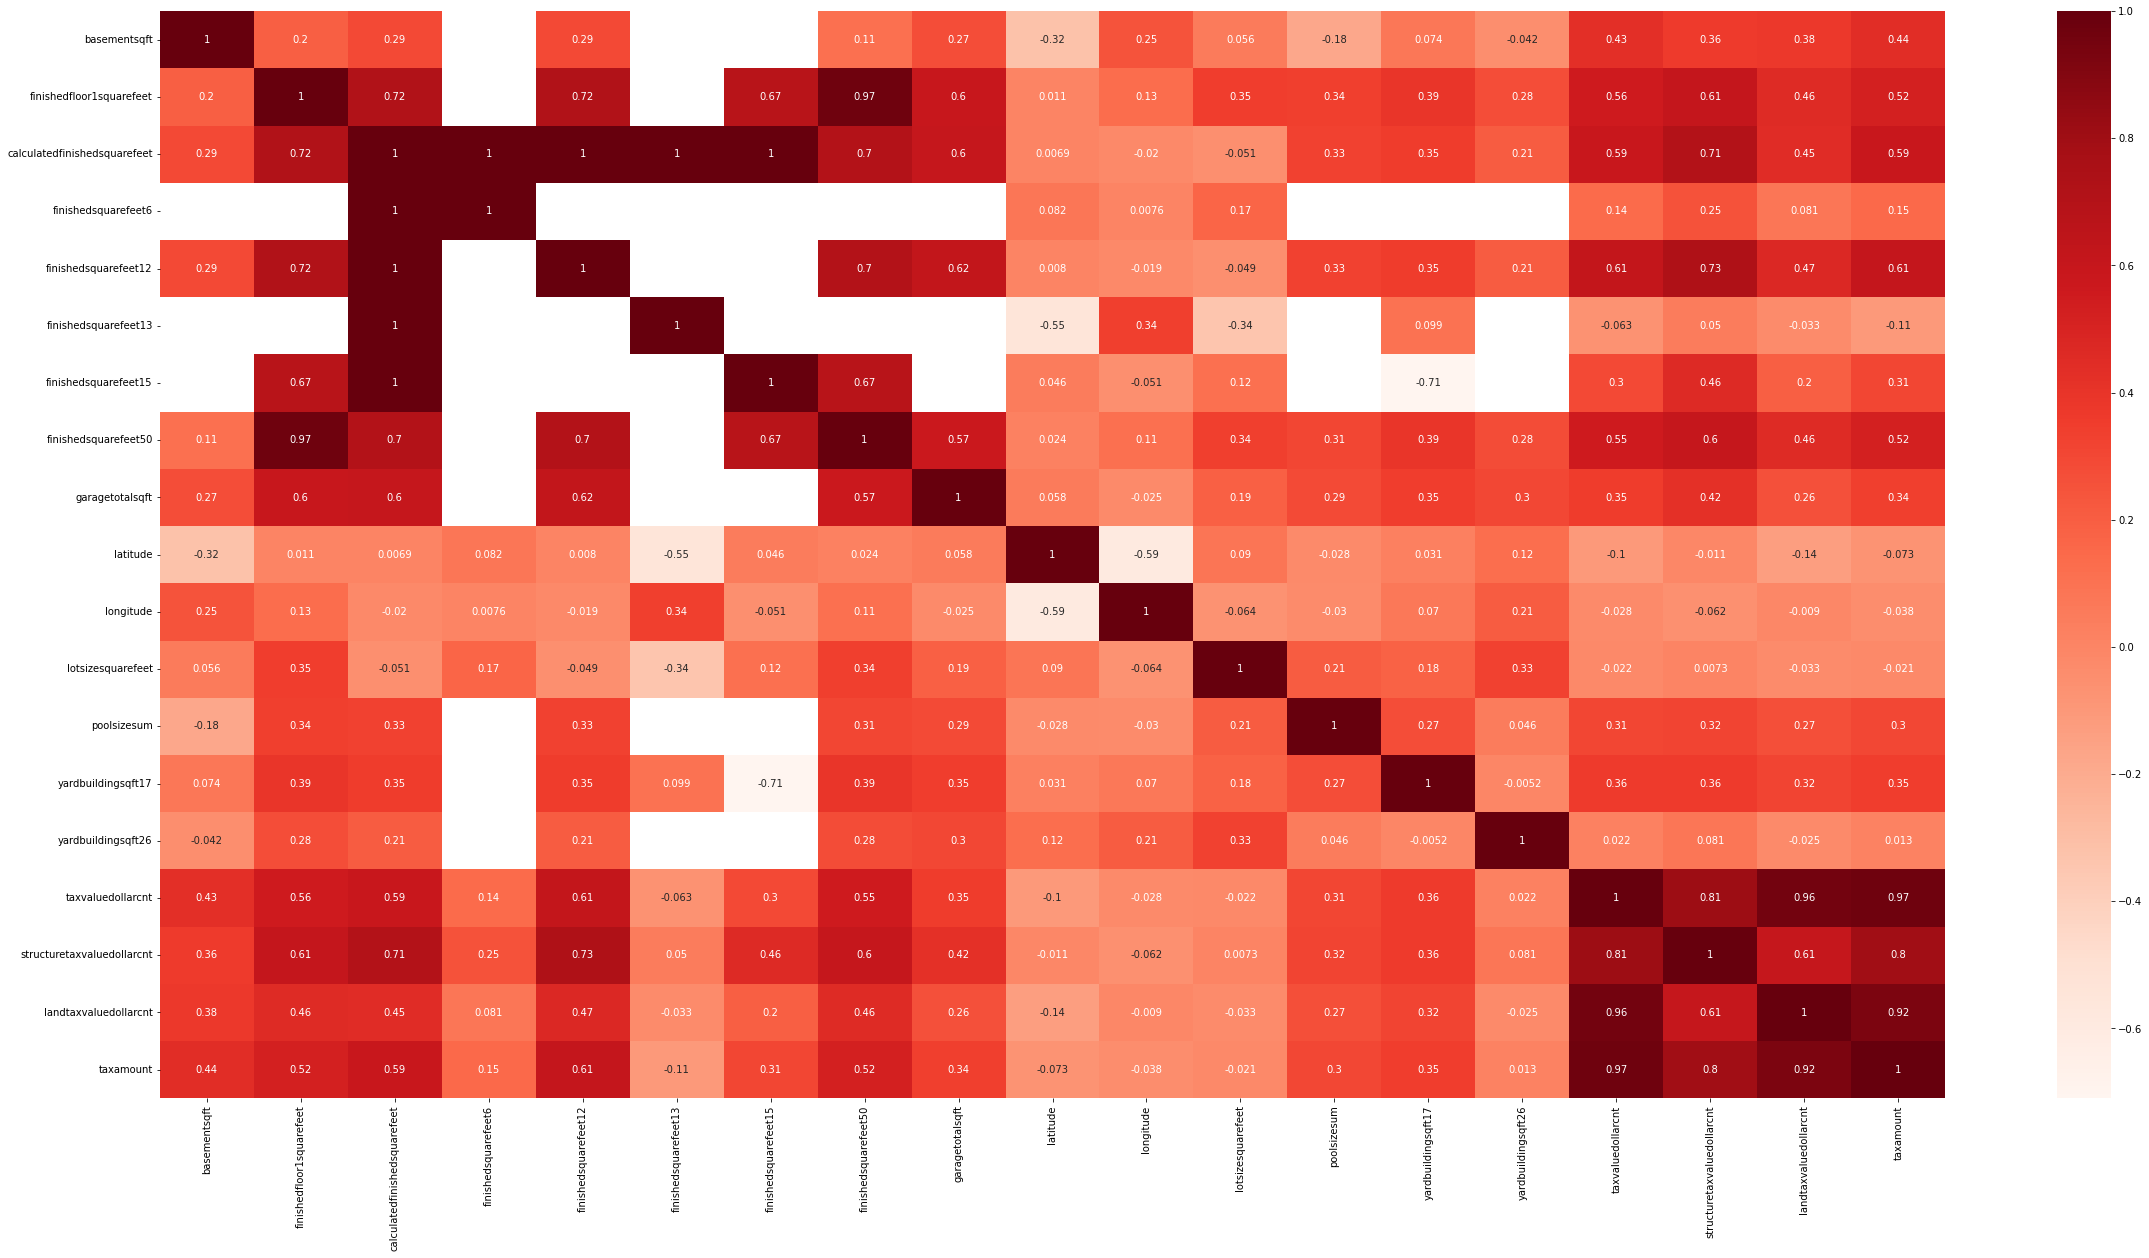

In [84]:
dfCorr = combined[numeric_features].corr(method="pearson")
filteredDf = dfCorr[((dfCorr >= 0.9) | (dfCorr <= 1))]
plt.figure(figsize=(40,20))
sns.heatmap(filteredDf, cmap="Reds", annot=True)
# plt.show()

#### calculatedfinishedsquarefeet, finishedsquarefeet6, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15 are perfectly correlated

In [85]:
percent_missing = combined[["calculatedfinishedsquarefeet", "finishedsquarefeet6", "finishedsquarefeet12", "finishedsquarefeet13", "finishedsquarefeet15"]].isnull().sum() * 100/ len(combined)
percent_missing

calculatedfinishedsquarefeet     0.533689
finishedsquarefeet6             99.519322
finishedsquarefeet12             4.984871
finishedsquarefeet13            99.955327
finishedsquarefeet15            96.074168
dtype: float64

In [86]:
#keeping the one with least % missing, which is calculatedfinishedsquarefeet
toDrop = ["finishedsquarefeet6", "finishedsquarefeet12", "finishedsquarefeet13", "finishedsquarefeet15"]

#### finishedsquarefeet50 and finishedfloor1squarefeet are highly correlated

In [87]:
percent_missing = combined[["finishedsquarefeet50", "finishedfloor1squarefeet"]].isnull().sum() * 100/ len(combined)
percent_missing

finishedsquarefeet50        92.320476
finishedfloor1squarefeet    92.320476
dtype: float64

In [88]:
#both are equal, thus we choose to drop 1 randomly (finishedsquarefeet50)
toDrop += ["finishedsquarefeet50"]
toDrop

['finishedsquarefeet6',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50']

#### taxvaluedollarcnt, taxamount and landtaxvaluedollarcnt are highly correlated

In [89]:
percent_missing = combined[["taxvaluedollarcnt", "taxamount", "landtaxvaluedollarcnt"]].isnull().sum() * 100/ len(combined)
percent_missing

taxvaluedollarcnt        0.021443
taxamount                0.026804
landtaxvaluedollarcnt    0.022039
dtype: float64

In [90]:
#keeping the one with least % missing, which is taxvaluedollarcnt        
toDrop += ["taxamount", "landtaxvaluedollarcnt"]
toDrop

['finishedsquarefeet6',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'taxamount',
 'landtaxvaluedollarcnt']

#### Dropping them from our numerical list and combined df

In [91]:
numeric_features2 = list(set(numeric_features) - set(toDrop))
numeric_features2

['structuretaxvaluedollarcnt',
 'finishedfloor1squarefeet',
 'garagetotalsqft',
 'longitude',
 'calculatedfinishedsquarefeet',
 'taxvaluedollarcnt',
 'yardbuildingsqft17',
 'latitude',
 'yardbuildingsqft26',
 'lotsizesquarefeet',
 'basementsqft',
 'poolsizesum']

In [92]:
combined.drop(toDrop, inplace = True, axis=1)

print(combined.shape)
print(combined.shape)

(167888, 45)
(167888, 45)


## Populating NaN values (0 for numerical columns, empty string for categorical columns)

In [93]:
combined[numeric_features2] = combined[numeric_features2].fillna(0)

In [94]:
combined[new_categorical_features] = combined[new_categorical_features].fillna('')

## Converting all categorical feature values to strings (a requirement for catBoost)

In [95]:
for i in new_categorical_features:
    combined[i] = combined[i].astype(str)

In [96]:
combined

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,2016,1,1.0,,0.0,2.0,3.0,,...,1.0,0.0,0.0,1959.0,,122754.0,360170.0,2015.0,,60371066461001.0
1,14366692,-0.168400,2016,1,,,0.0,3.5,4.0,,...,,0.0,0.0,2014.0,,346458.0,585529.0,2015.0,,
2,12098116,-0.004000,2016,1,1.0,,0.0,3.0,2.0,,...,1.0,0.0,0.0,1940.0,,61994.0,119906.0,2015.0,,60374638003004.0
3,12643413,0.021800,2016,1,1.0,,0.0,2.0,2.0,,...,1.0,0.0,0.0,1987.0,,171518.0,244880.0,2015.0,,60372963002002.0
4,14432541,-0.005000,2016,1,,,0.0,2.5,4.0,,...,,0.0,0.0,1981.0,2.0,169574.0,434551.0,2015.0,,60590423381006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,10833991,-0.002245,2017,21,1.0,,0.0,3.0,3.0,,...,1.0,0.0,0.0,1980.0,,265000.0,379000.0,2016.0,,60371319001006.0
77609,11000655,0.020615,2017,21,,,0.0,2.0,2.0,,...,1.0,0.0,0.0,1940.0,,70917.0,354621.0,2016.0,,60371014003002.0
77610,17239384,0.013209,2017,21,,,0.0,2.0,4.0,,...,,656.0,0.0,1964.0,1.0,50683.0,67205.0,2016.0,,61110084022016.0
77611,12773139,0.037129,2017,21,1.0,,0.0,1.0,3.0,,...,1.0,0.0,0.0,1954.0,,32797.0,49546.0,2016.0,,60374338022005.0


## Getting our train / test splits


In [97]:
y = combined["logerror"]
X = combined.drop(["parcelid", "logerror"], axis=1)

In [98]:
print(X.shape)
X.head()

(167888, 43)


,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,taxdelinquencyyear,censustractandblock
0,2016,1,1.0,,0.0,2.0,3.0,,4.0,2.0,...,1.0,0.0,0.0,1959.0,,122754.0,360170.0,2015.0,,60371066461001.0
1,2016,1,,,0.0,3.5,4.0,,,3.5,...,,0.0,0.0,2014.0,,346458.0,585529.0,2015.0,,
2,2016,1,1.0,,0.0,3.0,2.0,,4.0,3.0,...,1.0,0.0,0.0,1940.0,,61994.0,119906.0,2015.0,,60374638003004.0
3,2016,1,1.0,,0.0,2.0,2.0,,4.0,2.0,...,1.0,0.0,0.0,1987.0,,171518.0,244880.0,2015.0,,60372963002002.0
4,2016,1,,,0.0,2.5,4.0,,,2.5,...,,0.0,0.0,1981.0,2.0,169574.0,434551.0,2015.0,,60590423381006.0


In [99]:
y.head()

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float64

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

print(f"X_train size: {len(X_train)}")
print(f"X_test size: {len(X_test)}")
print(f"y_train size: {len(y_train)}")
print(f"y_test size: {len(y_test)}")

X_train size: 134310
X_test size: 33578
y_train size: 134310
y_test size: 33578


In [101]:
X_train.head()

,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,taxdelinquencyyear,censustractandblock
1145,2016,1,,,0.0,3.0,2.0,,1.0,3.0,...,1.0,0.0,0.0,1981.0,,254938.0,410564.0,2015.0,,60372641031011.0
46858,2017,18,,,0.0,2.0,3.0,,6.0,2.0,...,1.0,0.0,0.0,1947.0,,35960.0,108540.0,2016.0,,60371411021004.0
26074,2017,16,,,0.0,2.5,3.0,,,2.5,...,,814.0,0.0,1990.0,2.0,256156.0,512312.0,2016.0,,61110076141139.0
43052,2016,6,,,0.0,2.0,3.0,,4.0,2.0,...,1.0,0.0,0.0,1926.0,,97580.0,166558.0,2015.0,,60372141004000.0
76357,2016,9,,,0.0,1.0,1.0,,,1.0,...,,0.0,0.0,1930.0,2.0,10547.0,410000.0,2015.0,,60590320111002.0


In [102]:
y_train.head()

1145     0.045000
46858   -2.271428
26074    0.008852
43052   -0.098700
76357    0.035400
Name: logerror, dtype: float64

## Before we train a catBoost model, we need to get indices of categorical columns from X_train

In [103]:
categorical_indices = []
for i in new_categorical_features:
    idx = X_train.columns.get_loc(i)
    categorical_indices.append(idx)

categorical_indices.sort()
       
print(categorical_indices)

[0, 1, 2, 3, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 40, 41, 42]


## Preparing a submission onto kaggle

In [104]:
datelist = list(sample_submission.columns[1:])
print(datelist)
sample_submission

['201610', '201611', '201612', '201710', '201711', '201712']


,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2985212,168176230,0,0,0,0,0,0
2985213,14273630,0,0,0,0,0,0
2985214,168040630,0,0,0,0,0,0
2985215,168040830,0,0,0,0,0,0


## Function to preprocess our data as we did above

In [148]:
def preprocess(df):
    df[numeric_features2] = df[numeric_features2].fillna(0)
    df[new_categorical_features] = df[new_categorical_features].fillna('')
    
    for i in new_categorical_features:
        df[i] = df[i].astype(str)

def makeTransactionDF(df, month, year):
    data = {'transaction_year': [year for i in range(len(df))],
            'transaction_month': [month for i in range(len(df))]}
    
    transaction_month_year = pd.DataFrame(data)
    test_month_year = pd.concat([transaction_month_year, df], axis=1)
    
    return test_month_year

---
# Using oct 2016 to predict for all 6 time points 

1) Making a transaction df for October 2016

In [142]:
print(properties2016.shape)

(2985217, 49)


In [143]:
properties2016.drop(toDrop, inplace = True, axis=1)
print(properties2016.shape)

(2985217, 42)


In [145]:
test_oct_2016 = makeTransactionDF(properties2016, 10, 2016)

In [146]:
X_test_oct_2016 = test_oct_2016.drop('parcelid', axis=1)

print(X_test_oct_2016.shape)
X_test_oct_2016.head()

(2985217, 43)


,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,taxdelinquencyyear,censustractandblock
0,2016,10,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,NaN,NaN
1,2016,10,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,NaN,NaN
2,2016,10,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,NaN,NaN
3,2016,10,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,...,NaN,NaN,NaN,1948.0,1.0,571346.0,1156834.0,2015.0,NaN,NaN
4,2016,10,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,...,1.0,NaN,NaN,1947.0,NaN,193796.0,433491.0,2015.0,NaN,NaN


### Preprocessing our test set

In [149]:
preprocess(X_test_oct_2016)

In [150]:
X_test_oct_2016

,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,taxdelinquencyyear,censustractandblock
0,2016,10,,,0.0,0.0,0.0,,,,...,,0.0,0.0,,,0.0,9.0,2015.0,,
1,2016,10,,,0.0,0.0,0.0,,,,...,,0.0,0.0,,,0.0,27516.0,2015.0,,
2,2016,10,,,0.0,0.0,0.0,,,,...,2.0,0.0,0.0,,,650756.0,1413387.0,2015.0,,
3,2016,10,,,0.0,0.0,0.0,3.0,7.0,,...,,0.0,0.0,1948.0,1.0,571346.0,1156834.0,2015.0,,
4,2016,10,,,0.0,0.0,0.0,4.0,,,...,1.0,0.0,0.0,1947.0,,193796.0,433491.0,2015.0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,2016,10,,,0.0,,,,,,...,,0.0,0.0,,,0.0,0.0,,,
2985213,2016,10,,,0.0,,,,,,...,,0.0,0.0,,,0.0,0.0,,,
2985214,2016,10,,,0.0,,,,,,...,,0.0,0.0,,,0.0,0.0,,,
2985215,2016,10,,,0.0,,,,,,...,,0.0,0.0,,,0.0,0.0,,,


# Training and Prediction

## With Ensemble (1000 iterations)

In [152]:
num_ensembles = 5
y_pred = 0.0
for i in tqdm(range(num_ensembles)):
    model = CatBoostRegressor(
        iterations=1000, 
        learning_rate=0.03,
        depth=6, 
        l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        cat_features = categorical_indices,
        random_seed=i)
    
    model.fit(X_train, y_train)

    y_pred += model.predict(X_test_oct_2016)
    
y_pred /= num_ensembles

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0:	learn: 0.0688227	total: 381ms	remaining: 6m 20s
1:	learn: 0.0688052	total: 785ms	remaining: 6m 31s
2:	learn: 0.0687892	total: 1.19s	remaining: 6m 36s
3:	learn: 0.0687745	total: 1.57s	remaining: 6m 31s
4:	learn: 0.0687603	total: 2s	remaining: 6m 37s
5:	learn: 0.0687451	total: 2.4s	remaining: 6m 37s
6:	learn: 0.0687317	total: 2.79s	remaining: 6m 36s
7:	learn: 0.0687189	total: 3.19s	remaining: 6m 35s
8:	learn: 0.0687072	total: 3.59s	remaining: 6m 35s
9:	learn: 0.0686941	total: 3.94s	remaining: 6m 29s
10:	learn: 0.0686826	total: 4.35s	remaining: 6m 31s
11:	learn: 0.0686708	total: 4.77s	remaining: 6m 33s
12:	learn: 0.0686599	total: 5.16s	remaining: 6m 31s
13:	learn: 0.0686484	total: 5.52s	remaining: 6m 28s
14:	learn: 0.0686385	total: 5.86s	remaining: 6m 24s
15:	learn: 0.0686292	total: 6.23s	remaining: 6m 23s
16:	learn: 0.0686200	total: 6.61s	remaining: 6m 22s
17:	learn: 0.0686109	total: 6.98s	remaining: 6m 20s
18:	learn: 0.0686021	total: 7.36s	remaining: 6m 19s
19:	learn: 0.0685937	total

158:	learn: 0.0681609	total: 1m 19s	remaining: 6m 58s
159:	learn: 0.0681600	total: 1m 19s	remaining: 6m 57s
160:	learn: 0.0681587	total: 1m 20s	remaining: 6m 57s
161:	learn: 0.0681567	total: 1m 20s	remaining: 6m 56s
162:	learn: 0.0681556	total: 1m 21s	remaining: 6m 56s
163:	learn: 0.0681541	total: 1m 21s	remaining: 6m 56s
164:	learn: 0.0681518	total: 1m 22s	remaining: 6m 56s
165:	learn: 0.0681508	total: 1m 22s	remaining: 6m 55s
166:	learn: 0.0681493	total: 1m 23s	remaining: 6m 54s
167:	learn: 0.0681480	total: 1m 23s	remaining: 6m 54s
168:	learn: 0.0681469	total: 1m 24s	remaining: 6m 54s
169:	learn: 0.0681454	total: 1m 24s	remaining: 6m 53s
170:	learn: 0.0681418	total: 1m 25s	remaining: 6m 52s
171:	learn: 0.0681409	total: 1m 25s	remaining: 6m 52s
172:	learn: 0.0681400	total: 1m 26s	remaining: 6m 52s
173:	learn: 0.0681378	total: 1m 26s	remaining: 6m 51s
174:	learn: 0.0681369	total: 1m 27s	remaining: 6m 51s
175:	learn: 0.0681361	total: 1m 27s	remaining: 6m 50s
176:	learn: 0.0681346	total:

311:	learn: 0.0679758	total: 2m 37s	remaining: 5m 47s
312:	learn: 0.0679747	total: 2m 38s	remaining: 5m 46s
313:	learn: 0.0679736	total: 2m 38s	remaining: 5m 46s
314:	learn: 0.0679726	total: 2m 38s	remaining: 5m 45s
315:	learn: 0.0679707	total: 2m 39s	remaining: 5m 45s
316:	learn: 0.0679693	total: 2m 40s	remaining: 5m 44s
317:	learn: 0.0679688	total: 2m 40s	remaining: 5m 44s
318:	learn: 0.0679679	total: 2m 41s	remaining: 5m 43s
319:	learn: 0.0679672	total: 2m 41s	remaining: 5m 43s
320:	learn: 0.0679665	total: 2m 42s	remaining: 5m 43s
321:	learn: 0.0679657	total: 2m 42s	remaining: 5m 42s
322:	learn: 0.0679652	total: 2m 43s	remaining: 5m 42s
323:	learn: 0.0679645	total: 2m 43s	remaining: 5m 41s
324:	learn: 0.0679642	total: 2m 44s	remaining: 5m 40s
325:	learn: 0.0679630	total: 2m 44s	remaining: 5m 40s
326:	learn: 0.0679619	total: 2m 45s	remaining: 5m 39s
327:	learn: 0.0679606	total: 2m 45s	remaining: 5m 39s
328:	learn: 0.0679601	total: 2m 46s	remaining: 5m 38s
329:	learn: 0.0679590	total:

464:	learn: 0.0678194	total: 3m 53s	remaining: 4m 28s
465:	learn: 0.0678185	total: 3m 53s	remaining: 4m 27s
466:	learn: 0.0678179	total: 3m 54s	remaining: 4m 27s
467:	learn: 0.0678175	total: 3m 54s	remaining: 4m 26s
468:	learn: 0.0678155	total: 3m 55s	remaining: 4m 26s
469:	learn: 0.0678135	total: 3m 55s	remaining: 4m 25s
470:	learn: 0.0678115	total: 3m 55s	remaining: 4m 25s
471:	learn: 0.0678103	total: 3m 56s	remaining: 4m 24s
472:	learn: 0.0678088	total: 3m 56s	remaining: 4m 23s
473:	learn: 0.0678076	total: 3m 57s	remaining: 4m 23s
474:	learn: 0.0678061	total: 3m 57s	remaining: 4m 22s
475:	learn: 0.0678056	total: 3m 58s	remaining: 4m 22s
476:	learn: 0.0678039	total: 3m 58s	remaining: 4m 21s
477:	learn: 0.0678034	total: 3m 59s	remaining: 4m 21s
478:	learn: 0.0678025	total: 3m 59s	remaining: 4m 20s
479:	learn: 0.0678020	total: 4m	remaining: 4m 20s
480:	learn: 0.0678008	total: 4m	remaining: 4m 19s
481:	learn: 0.0677990	total: 4m 1s	remaining: 4m 19s
482:	learn: 0.0677967	total: 4m 1s	re

618:	learn: 0.0676728	total: 5m 10s	remaining: 3m 10s
619:	learn: 0.0676722	total: 5m 10s	remaining: 3m 10s
620:	learn: 0.0676714	total: 5m 11s	remaining: 3m 9s
621:	learn: 0.0676705	total: 5m 11s	remaining: 3m 9s
622:	learn: 0.0676692	total: 5m 12s	remaining: 3m 8s
623:	learn: 0.0676686	total: 5m 12s	remaining: 3m 8s
624:	learn: 0.0676678	total: 5m 13s	remaining: 3m 7s
625:	learn: 0.0676674	total: 5m 13s	remaining: 3m 7s
626:	learn: 0.0676668	total: 5m 13s	remaining: 3m 6s
627:	learn: 0.0676664	total: 5m 14s	remaining: 3m 6s
628:	learn: 0.0676661	total: 5m 14s	remaining: 3m 5s
629:	learn: 0.0676649	total: 5m 15s	remaining: 3m 5s
630:	learn: 0.0676645	total: 5m 16s	remaining: 3m 4s
631:	learn: 0.0676636	total: 5m 16s	remaining: 3m 4s
632:	learn: 0.0676631	total: 5m 17s	remaining: 3m 3s
633:	learn: 0.0676617	total: 5m 17s	remaining: 3m 3s
634:	learn: 0.0676615	total: 5m 18s	remaining: 3m 3s
635:	learn: 0.0676609	total: 5m 18s	remaining: 3m 2s
636:	learn: 0.0676594	total: 5m 19s	remainin

772:	learn: 0.0675541	total: 6m 26s	remaining: 1m 53s
773:	learn: 0.0675532	total: 6m 26s	remaining: 1m 52s
774:	learn: 0.0675530	total: 6m 27s	remaining: 1m 52s
775:	learn: 0.0675527	total: 6m 27s	remaining: 1m 51s
776:	learn: 0.0675524	total: 6m 28s	remaining: 1m 51s
777:	learn: 0.0675517	total: 6m 28s	remaining: 1m 50s
778:	learn: 0.0675502	total: 6m 29s	remaining: 1m 50s
779:	learn: 0.0675498	total: 6m 29s	remaining: 1m 49s
780:	learn: 0.0675492	total: 6m 30s	remaining: 1m 49s
781:	learn: 0.0675489	total: 6m 30s	remaining: 1m 48s
782:	learn: 0.0675480	total: 6m 31s	remaining: 1m 48s
783:	learn: 0.0675469	total: 6m 32s	remaining: 1m 48s
784:	learn: 0.0675464	total: 6m 32s	remaining: 1m 47s
785:	learn: 0.0675460	total: 6m 33s	remaining: 1m 47s
786:	learn: 0.0675452	total: 6m 33s	remaining: 1m 46s
787:	learn: 0.0675450	total: 6m 34s	remaining: 1m 46s
788:	learn: 0.0675437	total: 6m 34s	remaining: 1m 45s
789:	learn: 0.0675428	total: 6m 35s	remaining: 1m 45s
790:	learn: 0.0675411	total:

926:	learn: 0.0674526	total: 7m 43s	remaining: 36.5s
927:	learn: 0.0674512	total: 7m 43s	remaining: 36s
928:	learn: 0.0674508	total: 7m 44s	remaining: 35.5s
929:	learn: 0.0674507	total: 7m 44s	remaining: 35s
930:	learn: 0.0674504	total: 7m 45s	remaining: 34.5s
931:	learn: 0.0674498	total: 7m 45s	remaining: 34s
932:	learn: 0.0674492	total: 7m 46s	remaining: 33.5s
933:	learn: 0.0674487	total: 7m 47s	remaining: 33s
934:	learn: 0.0674483	total: 7m 47s	remaining: 32.5s
935:	learn: 0.0674480	total: 7m 48s	remaining: 32s
936:	learn: 0.0674459	total: 7m 48s	remaining: 31.5s
937:	learn: 0.0674454	total: 7m 49s	remaining: 31s
938:	learn: 0.0674449	total: 7m 49s	remaining: 30.5s
939:	learn: 0.0674437	total: 7m 50s	remaining: 30s
940:	learn: 0.0674433	total: 7m 50s	remaining: 29.5s
941:	learn: 0.0674432	total: 7m 51s	remaining: 29s
942:	learn: 0.0674419	total: 7m 51s	remaining: 28.5s
943:	learn: 0.0674417	total: 7m 52s	remaining: 28s
944:	learn: 0.0674408	total: 7m 52s	remaining: 27.5s
945:	learn:

 20%|████████████████▌                                                                  | 1/5 [09:16<37:07, 556.78s/it]

0:	learn: 0.0688204	total: 613ms	remaining: 10m 12s
1:	learn: 0.0688041	total: 1.15s	remaining: 9m 31s
2:	learn: 0.0687889	total: 1.6s	remaining: 8m 53s
3:	learn: 0.0687743	total: 2.2s	remaining: 9m 7s
4:	learn: 0.0687609	total: 2.68s	remaining: 8m 53s
5:	learn: 0.0687459	total: 3.21s	remaining: 8m 52s
6:	learn: 0.0687319	total: 3.73s	remaining: 8m 49s
7:	learn: 0.0687199	total: 4.33s	remaining: 8m 56s
8:	learn: 0.0687078	total: 4.86s	remaining: 8m 54s
9:	learn: 0.0686948	total: 5.34s	remaining: 8m 48s
10:	learn: 0.0686821	total: 5.93s	remaining: 8m 53s
11:	learn: 0.0686706	total: 6.49s	remaining: 8m 54s
12:	learn: 0.0686596	total: 7s	remaining: 8m 51s
13:	learn: 0.0686503	total: 7.5s	remaining: 8m 48s
14:	learn: 0.0686394	total: 8.01s	remaining: 8m 46s
15:	learn: 0.0686289	total: 8.55s	remaining: 8m 46s
16:	learn: 0.0686203	total: 9.07s	remaining: 8m 44s
17:	learn: 0.0686117	total: 9.6s	remaining: 8m 43s
18:	learn: 0.0686021	total: 10.1s	remaining: 8m 43s
19:	learn: 0.0685922	total: 1

157:	learn: 0.0681606	total: 1m 35s	remaining: 8m 29s
158:	learn: 0.0681587	total: 1m 36s	remaining: 8m 29s
159:	learn: 0.0681569	total: 1m 37s	remaining: 8m 30s
160:	learn: 0.0681548	total: 1m 38s	remaining: 8m 30s
161:	learn: 0.0681536	total: 1m 38s	remaining: 8m 30s
162:	learn: 0.0681513	total: 1m 39s	remaining: 8m 29s
163:	learn: 0.0681488	total: 1m 39s	remaining: 8m 28s
164:	learn: 0.0681475	total: 1m 40s	remaining: 8m 30s
165:	learn: 0.0681457	total: 1m 41s	remaining: 8m 31s
166:	learn: 0.0681444	total: 1m 42s	remaining: 8m 31s
167:	learn: 0.0681429	total: 1m 43s	remaining: 8m 30s
168:	learn: 0.0681422	total: 1m 43s	remaining: 8m 30s
169:	learn: 0.0681407	total: 1m 44s	remaining: 8m 29s
170:	learn: 0.0681396	total: 1m 45s	remaining: 8m 29s
171:	learn: 0.0681386	total: 1m 45s	remaining: 8m 28s
172:	learn: 0.0681366	total: 1m 46s	remaining: 8m 28s
173:	learn: 0.0681347	total: 1m 46s	remaining: 8m 27s
174:	learn: 0.0681331	total: 1m 47s	remaining: 8m 26s
175:	learn: 0.0681313	total:

310:	learn: 0.0679834	total: 2m 59s	remaining: 6m 36s
311:	learn: 0.0679826	total: 2m 59s	remaining: 6m 36s
312:	learn: 0.0679818	total: 3m	remaining: 6m 35s
313:	learn: 0.0679814	total: 3m	remaining: 6m 34s
314:	learn: 0.0679807	total: 3m 1s	remaining: 6m 33s
315:	learn: 0.0679804	total: 3m 1s	remaining: 6m 32s
316:	learn: 0.0679792	total: 3m 1s	remaining: 6m 31s
317:	learn: 0.0679787	total: 3m 2s	remaining: 6m 30s
318:	learn: 0.0679780	total: 3m 2s	remaining: 6m 30s
319:	learn: 0.0679775	total: 3m 3s	remaining: 6m 29s
320:	learn: 0.0679768	total: 3m 3s	remaining: 6m 28s
321:	learn: 0.0679761	total: 3m 4s	remaining: 6m 28s
322:	learn: 0.0679747	total: 3m 4s	remaining: 6m 27s
323:	learn: 0.0679743	total: 3m 5s	remaining: 6m 26s
324:	learn: 0.0679727	total: 3m 5s	remaining: 6m 25s
325:	learn: 0.0679720	total: 3m 6s	remaining: 6m 25s
326:	learn: 0.0679714	total: 3m 6s	remaining: 6m 24s
327:	learn: 0.0679708	total: 3m 7s	remaining: 6m 24s
328:	learn: 0.0679703	total: 3m 8s	remaining: 6m 2

464:	learn: 0.0678133	total: 4m 18s	remaining: 4m 57s
465:	learn: 0.0678119	total: 4m 19s	remaining: 4m 57s
466:	learn: 0.0678115	total: 4m 19s	remaining: 4m 56s
467:	learn: 0.0678104	total: 4m 20s	remaining: 4m 55s
468:	learn: 0.0678095	total: 4m 20s	remaining: 4m 55s
469:	learn: 0.0678076	total: 4m 21s	remaining: 4m 54s
470:	learn: 0.0678059	total: 4m 21s	remaining: 4m 54s
471:	learn: 0.0678050	total: 4m 22s	remaining: 4m 53s
472:	learn: 0.0678032	total: 4m 22s	remaining: 4m 52s
473:	learn: 0.0678025	total: 4m 23s	remaining: 4m 52s
474:	learn: 0.0678014	total: 4m 23s	remaining: 4m 51s
475:	learn: 0.0678002	total: 4m 24s	remaining: 4m 51s
476:	learn: 0.0677995	total: 4m 24s	remaining: 4m 50s
477:	learn: 0.0677988	total: 4m 25s	remaining: 4m 49s
478:	learn: 0.0677973	total: 4m 26s	remaining: 4m 49s
479:	learn: 0.0677962	total: 4m 26s	remaining: 4m 48s
480:	learn: 0.0677952	total: 4m 27s	remaining: 4m 48s
481:	learn: 0.0677936	total: 4m 27s	remaining: 4m 47s
482:	learn: 0.0677922	total:

617:	learn: 0.0676602	total: 5m 38s	remaining: 3m 29s
618:	learn: 0.0676591	total: 5m 38s	remaining: 3m 28s
619:	learn: 0.0676585	total: 5m 39s	remaining: 3m 27s
620:	learn: 0.0676579	total: 5m 39s	remaining: 3m 27s
621:	learn: 0.0676572	total: 5m 40s	remaining: 3m 26s
622:	learn: 0.0676555	total: 5m 40s	remaining: 3m 26s
623:	learn: 0.0676545	total: 5m 41s	remaining: 3m 25s
624:	learn: 0.0676532	total: 5m 41s	remaining: 3m 24s
625:	learn: 0.0676521	total: 5m 41s	remaining: 3m 24s
626:	learn: 0.0676517	total: 5m 42s	remaining: 3m 23s
627:	learn: 0.0676508	total: 5m 42s	remaining: 3m 23s
628:	learn: 0.0676488	total: 5m 43s	remaining: 3m 22s
629:	learn: 0.0676479	total: 5m 43s	remaining: 3m 21s
630:	learn: 0.0676467	total: 5m 44s	remaining: 3m 21s
631:	learn: 0.0676458	total: 5m 44s	remaining: 3m 20s
632:	learn: 0.0676452	total: 5m 45s	remaining: 3m 20s
633:	learn: 0.0676444	total: 5m 45s	remaining: 3m 19s
634:	learn: 0.0676426	total: 5m 46s	remaining: 3m 19s
635:	learn: 0.0676423	total:

770:	learn: 0.0675407	total: 6m 56s	remaining: 2m 3s
771:	learn: 0.0675404	total: 6m 57s	remaining: 2m 3s
772:	learn: 0.0675395	total: 6m 57s	remaining: 2m 2s
773:	learn: 0.0675390	total: 6m 58s	remaining: 2m 2s
774:	learn: 0.0675384	total: 6m 58s	remaining: 2m 1s
775:	learn: 0.0675374	total: 6m 59s	remaining: 2m 1s
776:	learn: 0.0675363	total: 6m 59s	remaining: 2m
777:	learn: 0.0675350	total: 7m	remaining: 1m 59s
778:	learn: 0.0675343	total: 7m	remaining: 1m 59s
779:	learn: 0.0675337	total: 7m 1s	remaining: 1m 58s
780:	learn: 0.0675324	total: 7m 1s	remaining: 1m 58s
781:	learn: 0.0675319	total: 7m 2s	remaining: 1m 57s
782:	learn: 0.0675309	total: 7m 2s	remaining: 1m 57s
783:	learn: 0.0675303	total: 7m 3s	remaining: 1m 56s
784:	learn: 0.0675297	total: 7m 3s	remaining: 1m 56s
785:	learn: 0.0675297	total: 7m 4s	remaining: 1m 55s
786:	learn: 0.0675293	total: 7m 4s	remaining: 1m 54s
787:	learn: 0.0675286	total: 7m 5s	remaining: 1m 54s
788:	learn: 0.0675283	total: 7m 5s	remaining: 1m 53s
78

925:	learn: 0.0674259	total: 8m 16s	remaining: 39.7s
926:	learn: 0.0674251	total: 8m 16s	remaining: 39.1s
927:	learn: 0.0674236	total: 8m 17s	remaining: 38.6s
928:	learn: 0.0674227	total: 8m 17s	remaining: 38s
929:	learn: 0.0674223	total: 8m 18s	remaining: 37.5s
930:	learn: 0.0674216	total: 8m 18s	remaining: 37s
931:	learn: 0.0674211	total: 8m 19s	remaining: 36.4s
932:	learn: 0.0674207	total: 8m 19s	remaining: 35.9s
933:	learn: 0.0674198	total: 8m 20s	remaining: 35.4s
934:	learn: 0.0674186	total: 8m 20s	remaining: 34.8s
935:	learn: 0.0674181	total: 8m 21s	remaining: 34.3s
936:	learn: 0.0674170	total: 8m 21s	remaining: 33.7s
937:	learn: 0.0674163	total: 8m 22s	remaining: 33.2s
938:	learn: 0.0674157	total: 8m 22s	remaining: 32.7s
939:	learn: 0.0674154	total: 8m 23s	remaining: 32.1s
940:	learn: 0.0674151	total: 8m 23s	remaining: 31.6s
941:	learn: 0.0674143	total: 8m 24s	remaining: 31.1s
942:	learn: 0.0674137	total: 8m 24s	remaining: 30.5s
943:	learn: 0.0674130	total: 8m 25s	remaining: 30s

 40%|█████████████████████████████████▏                                                 | 2/5 [19:08<28:51, 577.17s/it]

0:	learn: 0.0688209	total: 624ms	remaining: 10m 23s
1:	learn: 0.0688064	total: 1.39s	remaining: 11m 35s
2:	learn: 0.0687904	total: 2.1s	remaining: 11m 37s
3:	learn: 0.0687758	total: 2.91s	remaining: 12m 4s
4:	learn: 0.0687605	total: 3.52s	remaining: 11m 39s
5:	learn: 0.0687471	total: 4.04s	remaining: 11m 9s
6:	learn: 0.0687329	total: 4.53s	remaining: 10m 43s
7:	learn: 0.0687209	total: 5.02s	remaining: 10m 23s
8:	learn: 0.0687093	total: 5.5s	remaining: 10m 6s
9:	learn: 0.0686973	total: 6.01s	remaining: 9m 55s
10:	learn: 0.0686843	total: 6.51s	remaining: 9m 45s
11:	learn: 0.0686734	total: 7.01s	remaining: 9m 37s
12:	learn: 0.0686624	total: 7.5s	remaining: 9m 29s
13:	learn: 0.0686514	total: 8.01s	remaining: 9m 24s
14:	learn: 0.0686415	total: 8.67s	remaining: 9m 29s
15:	learn: 0.0686324	total: 9.17s	remaining: 9m 23s
16:	learn: 0.0686239	total: 9.69s	remaining: 9m 20s
17:	learn: 0.0686155	total: 10.2s	remaining: 9m 16s
18:	learn: 0.0686086	total: 10.6s	remaining: 9m 8s
19:	learn: 0.0685995

158:	learn: 0.0681637	total: 1m 29s	remaining: 7m 53s
159:	learn: 0.0681629	total: 1m 30s	remaining: 7m 53s
160:	learn: 0.0681619	total: 1m 31s	remaining: 7m 54s
161:	learn: 0.0681602	total: 1m 31s	remaining: 7m 54s
162:	learn: 0.0681587	total: 1m 32s	remaining: 7m 54s
163:	learn: 0.0681569	total: 1m 33s	remaining: 7m 55s
164:	learn: 0.0681553	total: 1m 33s	remaining: 7m 55s
165:	learn: 0.0681536	total: 1m 34s	remaining: 7m 55s
166:	learn: 0.0681515	total: 1m 35s	remaining: 7m 55s
167:	learn: 0.0681505	total: 1m 35s	remaining: 7m 55s
168:	learn: 0.0681489	total: 1m 36s	remaining: 7m 54s
169:	learn: 0.0681484	total: 1m 37s	remaining: 7m 54s
170:	learn: 0.0681454	total: 1m 37s	remaining: 7m 53s
171:	learn: 0.0681435	total: 1m 38s	remaining: 7m 53s
172:	learn: 0.0681426	total: 1m 38s	remaining: 7m 52s
173:	learn: 0.0681414	total: 1m 39s	remaining: 7m 52s
174:	learn: 0.0681401	total: 1m 40s	remaining: 7m 52s
175:	learn: 0.0681399	total: 1m 40s	remaining: 7m 49s
176:	learn: 0.0681392	total:

311:	learn: 0.0679832	total: 2m 52s	remaining: 6m 20s
312:	learn: 0.0679823	total: 2m 53s	remaining: 6m 19s
313:	learn: 0.0679805	total: 2m 53s	remaining: 6m 19s
314:	learn: 0.0679791	total: 2m 54s	remaining: 6m 18s
315:	learn: 0.0679785	total: 2m 54s	remaining: 6m 18s
316:	learn: 0.0679781	total: 2m 55s	remaining: 6m 17s
317:	learn: 0.0679773	total: 2m 55s	remaining: 6m 16s
318:	learn: 0.0679763	total: 2m 56s	remaining: 6m 16s
319:	learn: 0.0679756	total: 2m 56s	remaining: 6m 15s
320:	learn: 0.0679753	total: 2m 57s	remaining: 6m 14s
321:	learn: 0.0679751	total: 2m 57s	remaining: 6m 14s
322:	learn: 0.0679741	total: 2m 58s	remaining: 6m 13s
323:	learn: 0.0679734	total: 2m 58s	remaining: 6m 12s
324:	learn: 0.0679725	total: 2m 59s	remaining: 6m 12s
325:	learn: 0.0679711	total: 2m 59s	remaining: 6m 11s
326:	learn: 0.0679707	total: 3m	remaining: 6m 11s
327:	learn: 0.0679695	total: 3m	remaining: 6m 10s
328:	learn: 0.0679689	total: 3m 1s	remaining: 6m 9s
329:	learn: 0.0679677	total: 3m 1s	rem

465:	learn: 0.0678252	total: 4m 12s	remaining: 4m 49s
466:	learn: 0.0678238	total: 4m 13s	remaining: 4m 48s
467:	learn: 0.0678232	total: 4m 13s	remaining: 4m 48s
468:	learn: 0.0678226	total: 4m 14s	remaining: 4m 47s
469:	learn: 0.0678209	total: 4m 14s	remaining: 4m 47s
470:	learn: 0.0678203	total: 4m 15s	remaining: 4m 46s
471:	learn: 0.0678193	total: 4m 15s	remaining: 4m 45s
472:	learn: 0.0678181	total: 4m 16s	remaining: 4m 45s
473:	learn: 0.0678163	total: 4m 16s	remaining: 4m 44s
474:	learn: 0.0678157	total: 4m 17s	remaining: 4m 44s
475:	learn: 0.0678149	total: 4m 17s	remaining: 4m 43s
476:	learn: 0.0678141	total: 4m 18s	remaining: 4m 43s
477:	learn: 0.0678120	total: 4m 18s	remaining: 4m 42s
478:	learn: 0.0678111	total: 4m 19s	remaining: 4m 42s
479:	learn: 0.0678092	total: 4m 19s	remaining: 4m 41s
480:	learn: 0.0678070	total: 4m 20s	remaining: 4m 40s
481:	learn: 0.0678059	total: 4m 20s	remaining: 4m 40s
482:	learn: 0.0678046	total: 4m 21s	remaining: 4m 39s
483:	learn: 0.0678037	total:

618:	learn: 0.0676800	total: 5m 37s	remaining: 3m 27s
619:	learn: 0.0676787	total: 5m 37s	remaining: 3m 27s
620:	learn: 0.0676780	total: 5m 38s	remaining: 3m 26s
621:	learn: 0.0676774	total: 5m 38s	remaining: 3m 26s
622:	learn: 0.0676767	total: 5m 39s	remaining: 3m 25s
623:	learn: 0.0676765	total: 5m 39s	remaining: 3m 24s
624:	learn: 0.0676754	total: 5m 40s	remaining: 3m 24s
625:	learn: 0.0676747	total: 5m 40s	remaining: 3m 23s
626:	learn: 0.0676743	total: 5m 41s	remaining: 3m 23s
627:	learn: 0.0676739	total: 5m 41s	remaining: 3m 22s
628:	learn: 0.0676733	total: 5m 42s	remaining: 3m 21s
629:	learn: 0.0676729	total: 5m 42s	remaining: 3m 21s
630:	learn: 0.0676714	total: 5m 43s	remaining: 3m 20s
631:	learn: 0.0676709	total: 5m 43s	remaining: 3m 20s
632:	learn: 0.0676704	total: 5m 44s	remaining: 3m 19s
633:	learn: 0.0676701	total: 5m 44s	remaining: 3m 19s
634:	learn: 0.0676699	total: 5m 45s	remaining: 3m 18s
635:	learn: 0.0676690	total: 5m 45s	remaining: 3m 17s
636:	learn: 0.0676668	total:

771:	learn: 0.0675677	total: 6m 56s	remaining: 2m 2s
772:	learn: 0.0675671	total: 6m 56s	remaining: 2m 2s
773:	learn: 0.0675653	total: 6m 57s	remaining: 2m 1s
774:	learn: 0.0675643	total: 6m 57s	remaining: 2m 1s
775:	learn: 0.0675632	total: 6m 58s	remaining: 2m
776:	learn: 0.0675625	total: 6m 58s	remaining: 2m
777:	learn: 0.0675621	total: 6m 59s	remaining: 1m 59s
778:	learn: 0.0675618	total: 6m 59s	remaining: 1m 59s
779:	learn: 0.0675611	total: 7m	remaining: 1m 58s
780:	learn: 0.0675595	total: 7m	remaining: 1m 58s
781:	learn: 0.0675586	total: 7m 1s	remaining: 1m 57s
782:	learn: 0.0675583	total: 7m 2s	remaining: 1m 56s
783:	learn: 0.0675580	total: 7m 2s	remaining: 1m 56s
784:	learn: 0.0675577	total: 7m 3s	remaining: 1m 55s
785:	learn: 0.0675571	total: 7m 3s	remaining: 1m 55s
786:	learn: 0.0675568	total: 7m 4s	remaining: 1m 54s
787:	learn: 0.0675562	total: 7m 4s	remaining: 1m 54s
788:	learn: 0.0675553	total: 7m 5s	remaining: 1m 53s
789:	learn: 0.0675545	total: 7m 5s	remaining: 1m 53s
790

926:	learn: 0.0674716	total: 8m 16s	remaining: 39.1s
927:	learn: 0.0674710	total: 8m 17s	remaining: 38.6s
928:	learn: 0.0674705	total: 8m 17s	remaining: 38.1s
929:	learn: 0.0674687	total: 8m 18s	remaining: 37.5s
930:	learn: 0.0674682	total: 8m 18s	remaining: 37s
931:	learn: 0.0674677	total: 8m 19s	remaining: 36.4s
932:	learn: 0.0674669	total: 8m 19s	remaining: 35.9s
933:	learn: 0.0674666	total: 8m 20s	remaining: 35.4s
934:	learn: 0.0674664	total: 8m 20s	remaining: 34.8s
935:	learn: 0.0674656	total: 8m 21s	remaining: 34.3s
936:	learn: 0.0674650	total: 8m 21s	remaining: 33.7s
937:	learn: 0.0674647	total: 8m 22s	remaining: 33.2s
938:	learn: 0.0674642	total: 8m 22s	remaining: 32.7s
939:	learn: 0.0674640	total: 8m 23s	remaining: 32.1s
940:	learn: 0.0674630	total: 8m 23s	remaining: 31.6s
941:	learn: 0.0674626	total: 8m 24s	remaining: 31.1s
942:	learn: 0.0674625	total: 8m 24s	remaining: 30.5s
943:	learn: 0.0674619	total: 8m 25s	remaining: 30s
944:	learn: 0.0674615	total: 8m 25s	remaining: 29.

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [28:54<19:23, 581.53s/it]

0:	learn: 0.0688203	total: 506ms	remaining: 8m 25s
1:	learn: 0.0688025	total: 996ms	remaining: 8m 16s
2:	learn: 0.0687854	total: 1.46s	remaining: 8m 5s
3:	learn: 0.0687697	total: 1.9s	remaining: 7m 51s
4:	learn: 0.0687532	total: 2.33s	remaining: 7m 44s
5:	learn: 0.0687388	total: 2.78s	remaining: 7m 41s
6:	learn: 0.0687236	total: 3.29s	remaining: 7m 46s
7:	learn: 0.0687108	total: 3.77s	remaining: 7m 47s
8:	learn: 0.0686985	total: 4.26s	remaining: 7m 49s
9:	learn: 0.0686857	total: 4.74s	remaining: 7m 49s
10:	learn: 0.0686757	total: 5.27s	remaining: 7m 53s
11:	learn: 0.0686655	total: 5.75s	remaining: 7m 53s
12:	learn: 0.0686550	total: 6.21s	remaining: 7m 51s
13:	learn: 0.0686425	total: 6.74s	remaining: 7m 54s
14:	learn: 0.0686324	total: 7.23s	remaining: 7m 54s
15:	learn: 0.0686227	total: 7.75s	remaining: 7m 56s
16:	learn: 0.0686125	total: 8.27s	remaining: 7m 58s
17:	learn: 0.0686040	total: 8.85s	remaining: 8m 2s
18:	learn: 0.0685948	total: 9.27s	remaining: 7m 58s
19:	learn: 0.0685863	tota

158:	learn: 0.0681431	total: 1m 17s	remaining: 6m 48s
159:	learn: 0.0681415	total: 1m 17s	remaining: 6m 48s
160:	learn: 0.0681402	total: 1m 18s	remaining: 6m 47s
161:	learn: 0.0681382	total: 1m 18s	remaining: 6m 47s
162:	learn: 0.0681372	total: 1m 19s	remaining: 6m 46s
163:	learn: 0.0681358	total: 1m 19s	remaining: 6m 45s
164:	learn: 0.0681336	total: 1m 20s	remaining: 6m 45s
165:	learn: 0.0681309	total: 1m 20s	remaining: 6m 44s
166:	learn: 0.0681291	total: 1m 21s	remaining: 6m 44s
167:	learn: 0.0681276	total: 1m 21s	remaining: 6m 44s
168:	learn: 0.0681260	total: 1m 22s	remaining: 6m 43s
169:	learn: 0.0681245	total: 1m 22s	remaining: 6m 43s
170:	learn: 0.0681230	total: 1m 22s	remaining: 6m 42s
171:	learn: 0.0681218	total: 1m 23s	remaining: 6m 41s
172:	learn: 0.0681206	total: 1m 23s	remaining: 6m 41s
173:	learn: 0.0681194	total: 1m 24s	remaining: 6m 40s
174:	learn: 0.0681168	total: 1m 24s	remaining: 6m 39s
175:	learn: 0.0681156	total: 1m 25s	remaining: 6m 39s
176:	learn: 0.0681137	total:

311:	learn: 0.0679680	total: 2m 26s	remaining: 5m 23s
312:	learn: 0.0679672	total: 2m 27s	remaining: 5m 23s
313:	learn: 0.0679658	total: 2m 27s	remaining: 5m 22s
314:	learn: 0.0679654	total: 2m 28s	remaining: 5m 22s
315:	learn: 0.0679654	total: 2m 28s	remaining: 5m 20s
316:	learn: 0.0679647	total: 2m 28s	remaining: 5m 20s
317:	learn: 0.0679642	total: 2m 29s	remaining: 5m 19s
318:	learn: 0.0679636	total: 2m 29s	remaining: 5m 19s
319:	learn: 0.0679623	total: 2m 29s	remaining: 5m 18s
320:	learn: 0.0679621	total: 2m 30s	remaining: 5m 18s
321:	learn: 0.0679615	total: 2m 30s	remaining: 5m 17s
322:	learn: 0.0679610	total: 2m 31s	remaining: 5m 17s
323:	learn: 0.0679597	total: 2m 31s	remaining: 5m 16s
324:	learn: 0.0679595	total: 2m 32s	remaining: 5m 15s
325:	learn: 0.0679592	total: 2m 32s	remaining: 5m 14s
326:	learn: 0.0679585	total: 2m 32s	remaining: 5m 14s
327:	learn: 0.0679570	total: 2m 33s	remaining: 5m 13s
328:	learn: 0.0679560	total: 2m 33s	remaining: 5m 13s
329:	learn: 0.0679554	total:

464:	learn: 0.0678140	total: 3m 36s	remaining: 4m 8s
465:	learn: 0.0678123	total: 3m 36s	remaining: 4m 8s
466:	learn: 0.0678105	total: 3m 37s	remaining: 4m 7s
467:	learn: 0.0678097	total: 3m 37s	remaining: 4m 7s
468:	learn: 0.0678084	total: 3m 37s	remaining: 4m 6s
469:	learn: 0.0678081	total: 3m 38s	remaining: 4m 6s
470:	learn: 0.0678066	total: 3m 39s	remaining: 4m 5s
471:	learn: 0.0678045	total: 3m 39s	remaining: 4m 5s
472:	learn: 0.0678038	total: 3m 39s	remaining: 4m 5s
473:	learn: 0.0678018	total: 3m 40s	remaining: 4m 4s
474:	learn: 0.0678008	total: 3m 40s	remaining: 4m 4s
475:	learn: 0.0677999	total: 3m 41s	remaining: 4m 3s
476:	learn: 0.0677992	total: 3m 41s	remaining: 4m 3s
477:	learn: 0.0677986	total: 3m 42s	remaining: 4m 2s
478:	learn: 0.0677965	total: 3m 42s	remaining: 4m 2s
479:	learn: 0.0677954	total: 3m 43s	remaining: 4m 1s
480:	learn: 0.0677951	total: 3m 43s	remaining: 4m 1s
481:	learn: 0.0677938	total: 3m 44s	remaining: 4m
482:	learn: 0.0677931	total: 3m 44s	remaining: 4m

618:	learn: 0.0676564	total: 4m 48s	remaining: 2m 57s
619:	learn: 0.0676550	total: 4m 48s	remaining: 2m 56s
620:	learn: 0.0676546	total: 4m 48s	remaining: 2m 56s
621:	learn: 0.0676543	total: 4m 49s	remaining: 2m 55s
622:	learn: 0.0676538	total: 4m 49s	remaining: 2m 55s
623:	learn: 0.0676533	total: 4m 50s	remaining: 2m 54s
624:	learn: 0.0676520	total: 4m 50s	remaining: 2m 54s
625:	learn: 0.0676513	total: 4m 51s	remaining: 2m 54s
626:	learn: 0.0676501	total: 4m 51s	remaining: 2m 53s
627:	learn: 0.0676492	total: 4m 52s	remaining: 2m 53s
628:	learn: 0.0676483	total: 4m 52s	remaining: 2m 52s
629:	learn: 0.0676477	total: 4m 53s	remaining: 2m 52s
630:	learn: 0.0676470	total: 4m 53s	remaining: 2m 51s
631:	learn: 0.0676465	total: 4m 54s	remaining: 2m 51s
632:	learn: 0.0676445	total: 4m 54s	remaining: 2m 50s
633:	learn: 0.0676438	total: 4m 55s	remaining: 2m 50s
634:	learn: 0.0676429	total: 4m 55s	remaining: 2m 50s
635:	learn: 0.0676422	total: 4m 56s	remaining: 2m 49s
636:	learn: 0.0676413	total:

771:	learn: 0.0675270	total: 6m 2s	remaining: 1m 46s
772:	learn: 0.0675260	total: 6m 2s	remaining: 1m 46s
773:	learn: 0.0675252	total: 6m 3s	remaining: 1m 46s
774:	learn: 0.0675245	total: 6m 4s	remaining: 1m 45s
775:	learn: 0.0675236	total: 6m 4s	remaining: 1m 45s
776:	learn: 0.0675228	total: 6m 5s	remaining: 1m 44s
777:	learn: 0.0675225	total: 6m 6s	remaining: 1m 44s
778:	learn: 0.0675216	total: 6m 7s	remaining: 1m 44s
779:	learn: 0.0675209	total: 6m 7s	remaining: 1m 43s
780:	learn: 0.0675204	total: 6m 8s	remaining: 1m 43s
781:	learn: 0.0675200	total: 6m 9s	remaining: 1m 42s
782:	learn: 0.0675191	total: 6m 10s	remaining: 1m 42s
783:	learn: 0.0675184	total: 6m 10s	remaining: 1m 42s
784:	learn: 0.0675181	total: 6m 11s	remaining: 1m 41s
785:	learn: 0.0675169	total: 6m 12s	remaining: 1m 41s
786:	learn: 0.0675164	total: 6m 12s	remaining: 1m 40s
787:	learn: 0.0675156	total: 6m 13s	remaining: 1m 40s
788:	learn: 0.0675150	total: 6m 13s	remaining: 1m 39s
789:	learn: 0.0675147	total: 6m 14s	rem

926:	learn: 0.0674180	total: 7m 23s	remaining: 35s
927:	learn: 0.0674175	total: 7m 24s	remaining: 34.5s
928:	learn: 0.0674169	total: 7m 24s	remaining: 34s
929:	learn: 0.0674163	total: 7m 25s	remaining: 33.5s
930:	learn: 0.0674156	total: 7m 25s	remaining: 33s
931:	learn: 0.0674147	total: 7m 26s	remaining: 32.6s
932:	learn: 0.0674141	total: 7m 26s	remaining: 32.1s
933:	learn: 0.0674135	total: 7m 27s	remaining: 31.6s
934:	learn: 0.0674128	total: 7m 27s	remaining: 31.1s
935:	learn: 0.0674123	total: 7m 27s	remaining: 30.6s
936:	learn: 0.0674116	total: 7m 28s	remaining: 30.2s
937:	learn: 0.0674112	total: 7m 28s	remaining: 29.7s
938:	learn: 0.0674103	total: 7m 29s	remaining: 29.2s
939:	learn: 0.0674098	total: 7m 29s	remaining: 28.7s
940:	learn: 0.0674096	total: 7m 30s	remaining: 28.2s
941:	learn: 0.0674094	total: 7m 30s	remaining: 27.7s
942:	learn: 0.0674090	total: 7m 31s	remaining: 27.3s
943:	learn: 0.0674088	total: 7m 31s	remaining: 26.8s
944:	learn: 0.0674084	total: 7m 31s	remaining: 26.3s

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [37:46<09:21, 561.89s/it]

0:	learn: 0.0688222	total: 597ms	remaining: 9m 56s
1:	learn: 0.0688077	total: 1.09s	remaining: 9m 2s
2:	learn: 0.0687921	total: 1.65s	remaining: 9m 9s
3:	learn: 0.0687773	total: 2.27s	remaining: 9m 25s
4:	learn: 0.0687619	total: 2.88s	remaining: 9m 32s
5:	learn: 0.0687465	total: 3.4s	remaining: 9m 23s
6:	learn: 0.0687326	total: 3.94s	remaining: 9m 19s
7:	learn: 0.0687193	total: 4.53s	remaining: 9m 21s
8:	learn: 0.0687074	total: 5.05s	remaining: 9m 15s
9:	learn: 0.0686971	total: 5.53s	remaining: 9m 7s
10:	learn: 0.0686848	total: 6.09s	remaining: 9m 7s
11:	learn: 0.0686732	total: 6.66s	remaining: 9m 8s
12:	learn: 0.0686626	total: 7.18s	remaining: 9m 5s
13:	learn: 0.0686512	total: 7.76s	remaining: 9m 6s
14:	learn: 0.0686438	total: 8.19s	remaining: 8m 57s
15:	learn: 0.0686335	total: 8.71s	remaining: 8m 55s
16:	learn: 0.0686239	total: 9.31s	remaining: 8m 58s
17:	learn: 0.0686157	total: 9.84s	remaining: 8m 57s
18:	learn: 0.0686067	total: 10.4s	remaining: 8m 59s
19:	learn: 0.0685979	total: 11

157:	learn: 0.0681747	total: 1m 24s	remaining: 7m 32s
158:	learn: 0.0681730	total: 1m 25s	remaining: 7m 31s
159:	learn: 0.0681713	total: 1m 25s	remaining: 7m 31s
160:	learn: 0.0681692	total: 1m 26s	remaining: 7m 30s
161:	learn: 0.0681679	total: 1m 27s	remaining: 7m 30s
162:	learn: 0.0681668	total: 1m 27s	remaining: 7m 29s
163:	learn: 0.0681658	total: 1m 27s	remaining: 7m 28s
164:	learn: 0.0681648	total: 1m 28s	remaining: 7m 27s
165:	learn: 0.0681637	total: 1m 28s	remaining: 7m 26s
166:	learn: 0.0681626	total: 1m 29s	remaining: 7m 25s
167:	learn: 0.0681610	total: 1m 29s	remaining: 7m 25s
168:	learn: 0.0681595	total: 1m 30s	remaining: 7m 24s
169:	learn: 0.0681567	total: 1m 30s	remaining: 7m 23s
170:	learn: 0.0681553	total: 1m 31s	remaining: 7m 22s
171:	learn: 0.0681539	total: 1m 31s	remaining: 7m 21s
172:	learn: 0.0681525	total: 1m 32s	remaining: 7m 21s
173:	learn: 0.0681511	total: 1m 32s	remaining: 7m 20s
174:	learn: 0.0681496	total: 1m 33s	remaining: 7m 20s
175:	learn: 0.0681486	total:

310:	learn: 0.0679999	total: 2m 40s	remaining: 5m 56s
311:	learn: 0.0679990	total: 2m 41s	remaining: 5m 55s
312:	learn: 0.0679978	total: 2m 41s	remaining: 5m 55s
313:	learn: 0.0679971	total: 2m 42s	remaining: 5m 54s
314:	learn: 0.0679965	total: 2m 42s	remaining: 5m 54s
315:	learn: 0.0679955	total: 2m 43s	remaining: 5m 53s
316:	learn: 0.0679950	total: 2m 43s	remaining: 5m 53s
317:	learn: 0.0679945	total: 2m 44s	remaining: 5m 52s
318:	learn: 0.0679932	total: 2m 44s	remaining: 5m 51s
319:	learn: 0.0679906	total: 2m 45s	remaining: 5m 51s
320:	learn: 0.0679899	total: 2m 45s	remaining: 5m 50s
321:	learn: 0.0679893	total: 2m 46s	remaining: 5m 50s
322:	learn: 0.0679887	total: 2m 46s	remaining: 5m 49s
323:	learn: 0.0679878	total: 2m 47s	remaining: 5m 49s
324:	learn: 0.0679869	total: 2m 47s	remaining: 5m 48s
325:	learn: 0.0679862	total: 2m 48s	remaining: 5m 48s
326:	learn: 0.0679857	total: 2m 48s	remaining: 5m 47s
327:	learn: 0.0679851	total: 2m 49s	remaining: 5m 47s
328:	learn: 0.0679843	total:

463:	learn: 0.0678428	total: 3m 52s	remaining: 4m 28s
464:	learn: 0.0678412	total: 3m 53s	remaining: 4m 28s
465:	learn: 0.0678394	total: 3m 53s	remaining: 4m 27s
466:	learn: 0.0678383	total: 3m 54s	remaining: 4m 27s
467:	learn: 0.0678377	total: 3m 54s	remaining: 4m 26s
468:	learn: 0.0678361	total: 3m 54s	remaining: 4m 25s
469:	learn: 0.0678343	total: 3m 55s	remaining: 4m 25s
470:	learn: 0.0678333	total: 3m 55s	remaining: 4m 24s
471:	learn: 0.0678321	total: 3m 56s	remaining: 4m 24s
472:	learn: 0.0678313	total: 3m 56s	remaining: 4m 23s
473:	learn: 0.0678298	total: 3m 57s	remaining: 4m 23s
474:	learn: 0.0678291	total: 3m 57s	remaining: 4m 22s
475:	learn: 0.0678271	total: 3m 58s	remaining: 4m 22s
476:	learn: 0.0678265	total: 3m 58s	remaining: 4m 21s
477:	learn: 0.0678259	total: 3m 59s	remaining: 4m 21s
478:	learn: 0.0678247	total: 3m 59s	remaining: 4m 20s
479:	learn: 0.0678239	total: 4m	remaining: 4m 20s
480:	learn: 0.0678236	total: 4m	remaining: 4m 19s
481:	learn: 0.0678214	total: 4m	rema

617:	learn: 0.0676849	total: 5m 4s	remaining: 3m 7s
618:	learn: 0.0676838	total: 5m 4s	remaining: 3m 7s
619:	learn: 0.0676820	total: 5m 4s	remaining: 3m 6s
620:	learn: 0.0676811	total: 5m 5s	remaining: 3m 6s
621:	learn: 0.0676803	total: 5m 5s	remaining: 3m 5s
622:	learn: 0.0676785	total: 5m 6s	remaining: 3m 5s
623:	learn: 0.0676780	total: 5m 6s	remaining: 3m 4s
624:	learn: 0.0676768	total: 5m 7s	remaining: 3m 4s
625:	learn: 0.0676759	total: 5m 7s	remaining: 3m 3s
626:	learn: 0.0676739	total: 5m 8s	remaining: 3m 3s
627:	learn: 0.0676726	total: 5m 8s	remaining: 3m 2s
628:	learn: 0.0676719	total: 5m 9s	remaining: 3m 2s
629:	learn: 0.0676713	total: 5m 9s	remaining: 3m 1s
630:	learn: 0.0676699	total: 5m 10s	remaining: 3m 1s
631:	learn: 0.0676690	total: 5m 10s	remaining: 3m
632:	learn: 0.0676684	total: 5m 11s	remaining: 3m
633:	learn: 0.0676675	total: 5m 11s	remaining: 2m 59s
634:	learn: 0.0676668	total: 5m 12s	remaining: 2m 59s
635:	learn: 0.0676653	total: 5m 12s	remaining: 2m 58s
636:	lear

771:	learn: 0.0675533	total: 6m 17s	remaining: 1m 51s
772:	learn: 0.0675525	total: 6m 18s	remaining: 1m 51s
773:	learn: 0.0675521	total: 6m 18s	remaining: 1m 50s
774:	learn: 0.0675518	total: 6m 19s	remaining: 1m 50s
775:	learn: 0.0675510	total: 6m 19s	remaining: 1m 49s
776:	learn: 0.0675491	total: 6m 19s	remaining: 1m 49s
777:	learn: 0.0675487	total: 6m 20s	remaining: 1m 48s
778:	learn: 0.0675476	total: 6m 20s	remaining: 1m 48s
779:	learn: 0.0675470	total: 6m 21s	remaining: 1m 47s
780:	learn: 0.0675460	total: 6m 21s	remaining: 1m 47s
781:	learn: 0.0675452	total: 6m 22s	remaining: 1m 46s
782:	learn: 0.0675447	total: 6m 22s	remaining: 1m 46s
783:	learn: 0.0675441	total: 6m 23s	remaining: 1m 45s
784:	learn: 0.0675436	total: 6m 23s	remaining: 1m 45s
785:	learn: 0.0675430	total: 6m 24s	remaining: 1m 44s
786:	learn: 0.0675420	total: 6m 24s	remaining: 1m 44s
787:	learn: 0.0675413	total: 6m 25s	remaining: 1m 43s
788:	learn: 0.0675409	total: 6m 25s	remaining: 1m 43s
789:	learn: 0.0675398	total:

925:	learn: 0.0674512	total: 7m 33s	remaining: 36.2s
926:	learn: 0.0674508	total: 7m 33s	remaining: 35.7s
927:	learn: 0.0674501	total: 7m 34s	remaining: 35.2s
928:	learn: 0.0674487	total: 7m 34s	remaining: 34.8s
929:	learn: 0.0674485	total: 7m 35s	remaining: 34.3s
930:	learn: 0.0674472	total: 7m 35s	remaining: 33.8s
931:	learn: 0.0674464	total: 7m 35s	remaining: 33.3s
932:	learn: 0.0674453	total: 7m 36s	remaining: 32.8s
933:	learn: 0.0674440	total: 7m 36s	remaining: 32.3s
934:	learn: 0.0674434	total: 7m 37s	remaining: 31.8s
935:	learn: 0.0674428	total: 7m 37s	remaining: 31.3s
936:	learn: 0.0674420	total: 7m 38s	remaining: 30.8s
937:	learn: 0.0674417	total: 7m 38s	remaining: 30.3s
938:	learn: 0.0674412	total: 7m 39s	remaining: 29.8s
939:	learn: 0.0674404	total: 7m 39s	remaining: 29.3s
940:	learn: 0.0674400	total: 7m 39s	remaining: 28.8s
941:	learn: 0.0674395	total: 7m 40s	remaining: 28.3s
942:	learn: 0.0674383	total: 7m 40s	remaining: 27.9s
943:	learn: 0.0674378	total: 7m 41s	remaining:

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [46:41<00:00, 560.35s/it]


In [153]:
for i in datelist:
    sample_submission[i] = y_pred

In [154]:
sample_submission.to_csv("submission_ensemble_1000iterations_highCorrelationRemoved.csv", index=False)